In [1]:
import glob

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns

from tg import get_data_path, get_root_path
from tg.datasets import DATASET_FACTORY_LOOKUP

# color_palette = list(sns.color_palette("pastel").as_hex())
color_palette = list(sns.color_palette("husl", 9).as_hex())

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
dict_dataset_names = {
    "AIR_PASSENGERS": "Passageiros aéreos",
    "HOMICIDES": 'Homicídios dolosos no RJ',
    "NOISY_SINE30": "Seno ruidoso",
    "PERFECT_SINE30": "Seno perfeito",
    "RANDOM_WALK": "Caminhada aleatória"
}

dict_column_names = {
    "params.model_name": "Modelo",
    "metrics.rmse": "RMSE",
    "metrics.mae": "MAE",
    "metrics.mape": "MAPE",
    "metrics.smape": "sMAPE",
    "params.dataset_name": "Conjunto de dados"
}


In [3]:
mlflow.set_tracking_uri("file:///{}".format(get_root_path("mlruns")))
experiment = mlflow.get_experiment('0')

In [4]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs['artifact_uri'] = runs['artifact_uri'].apply(lambda x: x.replace(
    x.split('mlruns')[0], 'file///{}'.format(get_root_path(""))).replace(
        '\\', '/'))
runs.head(3)

Traceback (most recent call last):
  File "c:\Users\Gustavo-pessoal\programming\tg\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 826, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "c:\Users\Gustavo-pessoal\programming\tg\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 658, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\Gustavo-pessoal\programming\tg\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\Gustavo-pessoal\programming\tg\.venv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1068, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\Gustavo-pessoal\programming\tg\.venv\lib\site-packages\mlflow\utils\file_utils.py", line 181, in read_yaml
    raise MissingConfigException("Yaml file '%s' does

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.smape,metrics.mae,metrics.rmse,metrics.mape,params.dataset_name,params.n_train_points,params.params,params.model_name,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.git.commit,tags.mlflow.source.name
0,ebf9b1e6e3b74fc990dbb4b626ec3c4c,0,FINISHED,file///c:/users/gustavo-pessoal/programming/tg...,2022-11-06 18:13:28.227000+00:00,2022-11-06 18:13:29.352000+00:00,0.482617,0.009454,0.012435,0.968824,RANDOM_WALK,110,"{'alpha': 0.009396473889829494, 'damped_trend'...",ES_ELM,enthused-loon-481,LOCAL,Rafa,374b8ac2ca56b19b12f8487cbb6f04517c4e8016,.\src\tg\main.py
1,b8b676aaffed4e6d907f8918f40cc852,0,FINISHED,file///c:/users/gustavo-pessoal/programming/tg...,2022-11-06 17:59:44.077000+00:00,2022-11-06 17:59:44.741000+00:00,0.518453,0.009955,0.012853,1.040594,RANDOM_WALK,110,"{'alpha': 0.0003607294403623374, 'damped_trend...",ES_ELM,sedate-grub-525,LOCAL,Rafa,374b8ac2ca56b19b12f8487cbb6f04517c4e8016,.\src\tg\main.py
2,bbd5bb21d1224b48bfd44d5f1aa3dd4c,0,FINISHED,file///c:/users/gustavo-pessoal/programming/tg...,2022-11-06 17:59:16.063000+00:00,2022-11-06 17:59:21.636000+00:00,3.427171,26.988260,33.721142,6.916167,HOMICIDES,110,"{'alpha': 0.006850461336557157, 'damped_trend'...",ES_ELM,thundering-koi-616,LOCAL,Rafa,374b8ac2ca56b19b12f8487cbb6f04517c4e8016,.\src\tg\main.py


In [5]:
    # 'NAIVE': _get_default_input,
    # 'ARIMA': _get_default_input,
    # 'SARIMA': _get_default_input,
    # 'RNN': _get_lagged_input,
    # 'SVR': _get_lagged_input,
    # 'ELM': _get_lagged_input,
    # 'STL': _get_default_input,
    # 'ES': _get_default_input,
    # 'LSTM': _get_lagged_input,
    # 'ARIMA_RNN': _get_default_input,
    # 'SARIMA_SVR': _get_default_input,
    # 'STL_ELM': _get_default_input,
    # 'ES_LSTM': _get_default_input

In [6]:
metrics_table = runs[[
    "params.model_name", "metrics.rmse", "metrics.mape", "metrics.smape",
    "metrics.mae", "params.dataset_name"
]].copy()

metrics_table = metrics_table.rename(columns=dict_column_names)

columns_order = ["Modelo", "Conjunto de dados", "RMSE", "MAE", "MAPE", "sMAPE"]

metrics_table["Conjunto de dados"] = metrics_table[
    "Conjunto de dados"].replace(dict_dataset_names)

metrics_table = metrics_table.sort_values(["sMAPE"]).drop_duplicates(
    subset=["Conjunto de dados", "Modelo"],
    keep="first").sort_values(["Conjunto de dados",
                               "sMAPE"]).reset_index(drop=True)

np.round(metrics_table, 4).head(3)

,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados
0,ES,0.0111,0.7015,0.3521,0.0068,Caminhada aleatória
1,ARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória
2,SARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória


In [7]:
np.round(
    metrics_table[metrics_table['Conjunto de dados'] ==
                  dict_dataset_names['RANDOM_WALK']], 4)


,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados
0,ES,0.0111,0.7015,0.3521,0.0068,Caminhada aleatória
1,ARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória
2,SARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória
3,ELM,0.0116,0.9051,0.4517,0.0088,Caminhada aleatória
4,SARIMA_SVR,0.0115,0.9245,0.4618,0.0088,Caminhada aleatória
5,ES_ELM,0.0124,0.9688,0.4826,0.0095,Caminhada aleatória
6,STL_ELM,0.0127,1.0729,0.5379,0.0105,Caminhada aleatória
7,SVR,0.0127,1.0839,0.5398,0.0105,Caminhada aleatória
8,ARIMA_RNN,0.0146,1.1950,0.5979,0.0117,Caminhada aleatória
9,RNN,0.0258,1.8571,0.9171,0.0187,Caminhada aleatória


In [8]:
# _metrics_table = metrics_table[columns_order].round(1).set_index(
#     ["Conjunto de dados", "Modelo"])
# latex_metrics_table = _metrics_table.to_latex()
# print(latex_metrics_table)

In [9]:
preds = []
for _, row in runs[[
        "params.model_name", "params.dataset_name", "artifact_uri"
]].iterrows():
    model = row["params.model_name"]
    dataset = row["params.dataset_name"]
    artifact_uri = row["artifact_uri"].split("///")[-1]
    glob_pattern = f"{artifact_uri}/*.csv"
    aux = glob.glob(glob_pattern)
    if len(aux) > 0:
        path = aux[0]
        preds.append(pd.read_csv(path).iloc[:, 1].values)
    else:
        preds.append(np.nan)

runs["Predições"] = preds

In [10]:
preds_table = runs[[
    "params.model_name", "metrics.rmse", "metrics.mape", "metrics.smape",
    "metrics.mae", "params.dataset_name", "Predições"
]].copy()

preds_table = preds_table.rename(columns=dict_column_names)
columns_order = [
    "Modelo", "Conjunto de dados", "RMSE", "MAE", "MAPE", "sMAPE", "Predições"
]

preds_table["Conjunto de dados"] = preds_table["Conjunto de dados"].replace(
    dict_dataset_names)

preds_table = preds_table.sort_values(["sMAPE"]).drop_duplicates(
    subset=["Conjunto de dados", "Modelo"],
    keep="first").sort_values(["Conjunto de dados",
                               "sMAPE"]).reset_index(drop=True).dropna()

np.round(preds_table, 4)

,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados,Predições
0,ES,0.0111,0.7015,0.3521,0.0068,Caminhada aleatória,"[1.4545454542745244, 1.3727272735400635, 1.309..."
1,ARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória,"[1.4545454545454657, 1.37272725877498, 1.30909..."
2,SARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória,"[1.4545454545454657, 1.37272725877498, 1.30909..."
3,ELM,0.0116,0.9051,0.4517,0.0088,Caminhada aleatória,"[1.4598205817363, 1.380376889158171, 1.3165024..."
4,SARIMA_SVR,0.0115,0.9245,0.4618,0.0088,Caminhada aleatória,"[1.4551772004858463, 1.3788419538323151, 1.308..."
5,ES_ELM,0.0124,0.9688,0.4826,0.0095,Caminhada aleatória,"[1.4602997743282446, 1.3836173570617083, 1.315..."
6,STL_ELM,0.0127,1.0729,0.5379,0.0105,Caminhada aleatória,"[1.463540809985827, 1.3851957044445846, 1.3179..."
7,SVR,0.0127,1.0839,0.5398,0.0105,Caminhada aleatória,"[1.461173849771065, 1.3901276134555207, 1.3172..."
8,ARIMA_RNN,0.0146,1.1950,0.5979,0.0117,Caminhada aleatória,"[1.4483178, 1.3878971, 1.3466333, 1.2407963, 1..."
9,RNN,0.0258,1.8571,0.9171,0.0187,Caminhada aleatória,"[1.4620461, 1.4327053, 1.311759, 1.2662796, 1...."


In [11]:
HYBRID_MODELS = ["ARIMA_RNN", "SARIMA_SVR", "STL_ELM", "ES_LSTM", "ES_ELM"]
model_names = HYBRID_MODELS
ALL_MODELS = [
        'NAIVE', 'ARIMA', 'SARIMA', 'RNN', 'SVR', 'ELM', 'STL', 'ES', 'LSTM',
        'ARIMA_RNN', 'SARIMA_SVR', 'STL_ELM', 'ES_LSTM'
    ]
model_names = ALL_MODELS

# 'ELM', 'STL'

In [12]:
HYBRID_TRIPLES = [
    ("ARIMA", "RNN", "ARIMA_RNN"),
    ("SARIMA", "SVR", "SARIMA_SVR"),
    ("STL", "ELM", "STL_ELM"),
    ("ES", "LSTM", "ES_LSTM"),
    ("ES", "ELM", "ES_ELM"),
]


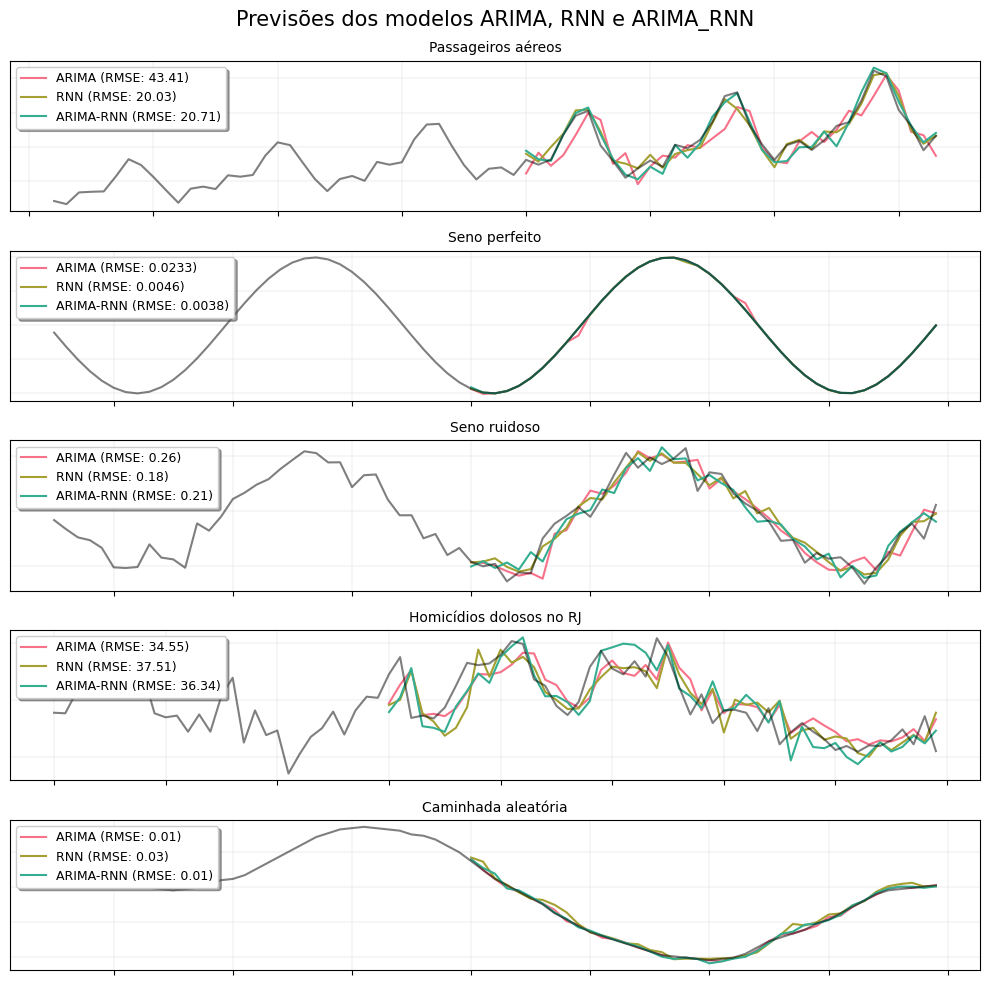

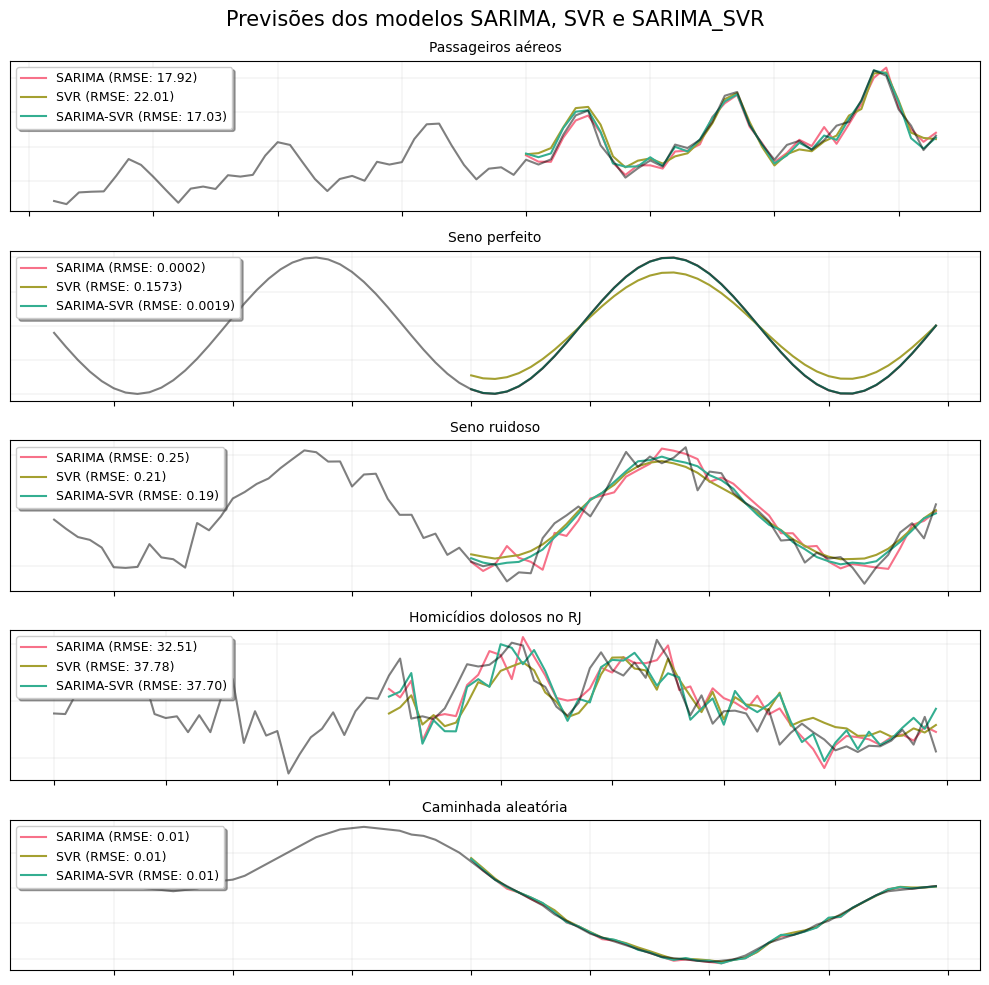

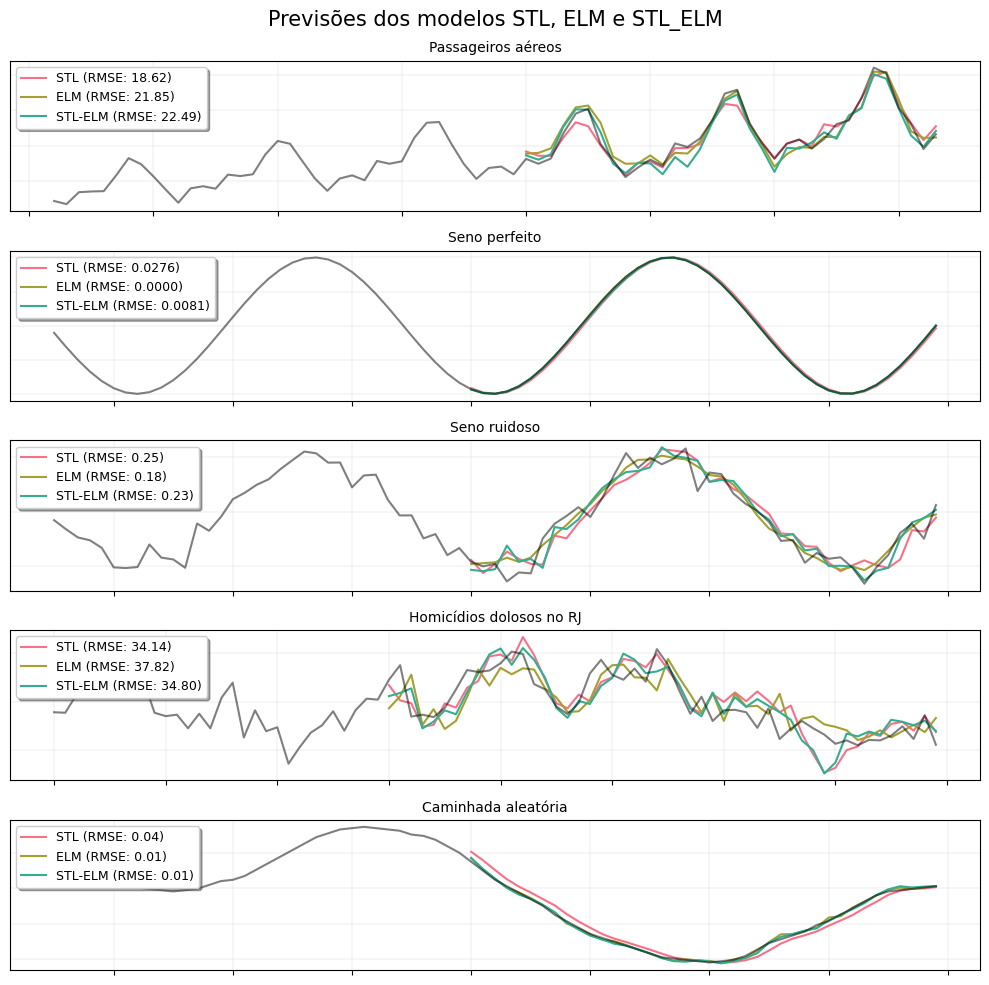

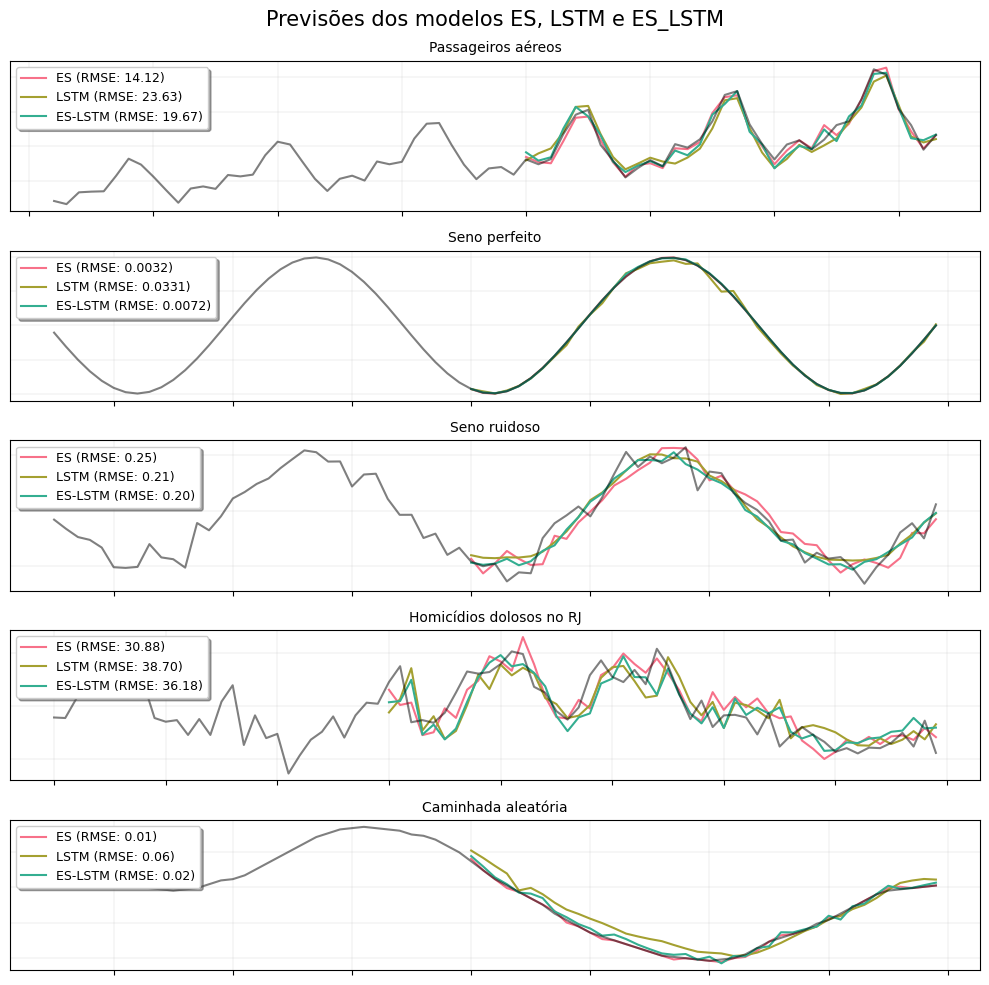

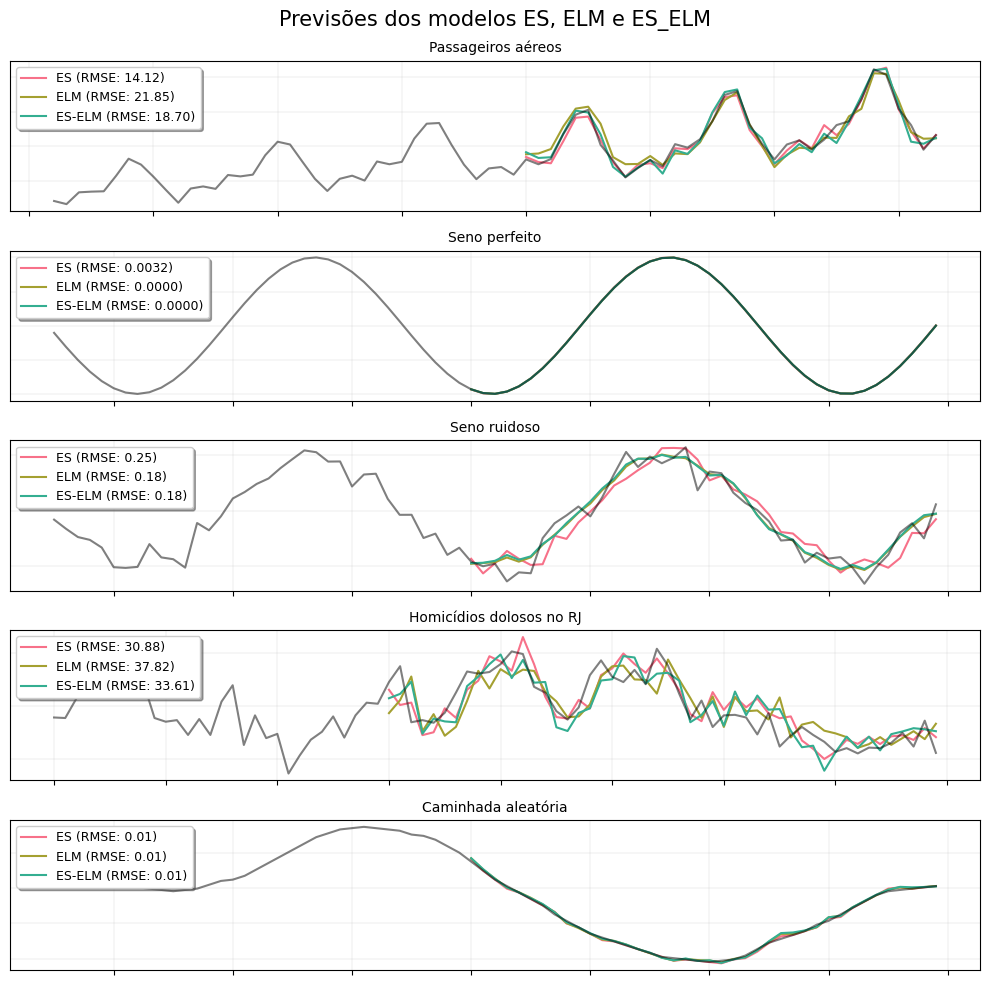

In [25]:
# dataset_name = list(DATASET_FACTORY_LOOKUP.keys())[0]

for model_triple in HYBRID_TRIPLES:

    fig, axs = plt.subplots(5, 1, figsize=(10, 10))

    for i, dataset_name in enumerate(DATASET_FACTORY_LOOKUP.keys()):

        series = DATASET_FACTORY_LOOKUP[dataset_name]()

        for j, model in enumerate(model_triple):
            aux_data = preds_table.loc[(preds_table['Modelo'] == model) &
                                    (preds_table['Conjunto de dados'] ==
                                        dict_dataset_names[dataset_name]), :]
            aux_pred = aux_data['Predições'].values[0]
            aux_model = '-'.join(model.split('_')).upper()

            if dataset_name == 'PERFECT_SINE30':
                axs[i].plot(range(len(series) - len(aux_pred), len(series)),
                            aux_pred,
                            color=color_palette[2*j],
                            label="{} (RMSE: {:.4f})".format(
                                aux_model, aux_data['RMSE'].values[0]))
            else:
                axs[i].plot(range(len(series) - len(aux_pred), len(series)),
                            aux_pred,
                            color=color_palette[2*j],
                            label="{} (RMSE: {:.2f})".format(
                                aux_model, aux_data['RMSE'].values[0]))

        axs[i].set_title(dict_dataset_names[dataset_name], fontsize=10)
        half_size = int(len(series) / 2)
        axs[i].plot(range(len(series) - half_size, len(series)), series[-half_size:], color='black', alpha=0.5)

    for ax in axs:
        for tick in ax.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.legend(fontsize=9, shadow=True, loc='upper left')
        ax.grid(linewidth=0.15)


    m0, m1, m2 = model_triple
    fig.suptitle(f"Previsões dos modelos {m0}, {m1} e {m2}", fontsize=15)
    plt.tight_layout()
    plt.savefig(get_root_path("reports/desempenho_triplets{}.png".format(
            model.lower())),
                    dpi=300)
    plt.show()


In [14]:
import re
import unicodedata
from math import log10, floor
from itertools import chain

def find_exp(number) -> int:
    base10 = log10(abs(number))
    return abs(floor(base10))

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode("utf-8")

ordered_models = [
    "ARIMA", "RNN", "ARIMA_RNN",
    "SARIMA", "SVR", "SARIMA_SVR",
    "STL", "ELM", "STL_ELM",
    "ES", "LSTM", "ES_LSTM"
]

groups = (
    preds_table.melt(  
        id_vars = ["Modelo", "Conjunto de dados"], 
        value_vars=["RMSE","MAPE","sMAPE","MAE"], 
        var_name = "Métrica", 
        value_name="Valor"
    )
    .query("Modelo != 'NAIVE'")
    .pivot_table(values="Valor", index = ["Conjunto de dados", "Modelo"], columns="Métrica")
    .groupby("Conjunto de dados")
)

rotate = lambda x: R"\STAB{\rotatebox[origin=c]{90}{" + x + R"}}"

datasets_names = ["Passageiros aéreos", "Seno perfeito", "Seno ruidoso", 'Homicídios dolosos no RJ', "Caminhada aleatória"]
datasets_results_map = {name: gp for name, gp in list(groups)}

tables = ""
for name in datasets_names:
    gp = datasets_results_map[name]
    gp.columns.name = ""
    
    idx_order = [(name, t) for t in ordered_models]
    gp = gp.loc[idx_order]

    min_by_col = gp.min().to_dict()
    max_exp_by_col = {col : max(2, find_exp(min_number)) for col, min_number in min_by_col.items()}
    format_str_by_col = {col: f"{{:.{max_exp}f}}" for col, max_exp in max_exp_by_col.items()}


    min_number = gp.min().min()
    max_exp = max(2, find_exp(min_number))
    format_str = f"{{:.{max_exp}f}}"

    colformat = ['c'] * (len(gp.columns) + 2)
    colformat = "" + " ".join(colformat) + ""
    
    # gp["Trinca"] = ([1 + i//3 for i in range(len(gp))])
    # gp = gp.reset_index().set_index(["Conjunto de dados", "Trinca", "Modelo"])
    
    t = (
        gp.style.highlight_min(
            color="none", 
            axis = 0, 
            props = "font-weight:bold"
        )
        # .format(format_str.format)
        .format(format_str_by_col)
        .format_index(escape="latex", axis=1)
        .format_index(escape="latex", axis=0)
        .to_latex(
            hrules=True, 
            convert_css=True, 
            column_format=colformat, 
            environment="table",
            caption=f"Comparação entre métricas no conjunto de dados {name}. Em negrito destacam-se os melhores resultados.",
            label=f"tab:results_per_dataset_{'_'.join(remove_accents(name).split())}", 
            position='H', 
            position_float="centering",
        )
    )
    tables += f"""{t}"""


pre = "{\n" + R"\newcommand{\STAB}[1]{\begin{tabular}{@{}c@{}}#1\end{tabular}}"
latex = pre + f"""\n{tables} }}"""

regex = r"(:?\\multirow\[c\]\{12\}\{\*\}\{)(:?[\w\s]+)(:?\})"
latex = re.sub(regex, r"\g<1>\\STAB{\\rotatebox[origin=c]{90}{\g<2>}}\g<3>", latex)

with open(get_root_path("reports/tables.tex"), "w+", encoding="utf-8") as f:
    f.write(latex)


In [15]:
modeltype_comparing_table = preds_table.groupby(['Conjunto de dados', 'Tipo dos modelos']).agg(['mean', 'median']).round(4)
modeltype_comparing_table

KeyError: 'Tipo dos modelos'

In [16]:
dataset_name = "Passageiros aéreos"

df_aux = pd.DataFrame()
for dataset_name in np.unique([x[0] for x in modeltype_comparing_table.index]):
    aux = modeltype_comparing_table.loc[dataset_name]
    df_aux = pd.concat([df_aux, pd.DataFrame(100 * np.round((aux.iloc[1, :] - aux.iloc[0, :]) / aux.iloc[1, :], 3), columns=[dataset_name])], axis=1)

df_aux

NameError: name 'modeltype_comparing_table' is not defined

In [17]:
df_aux.mean(axis=1)

Series([], dtype: float64)

In [18]:
time_table = runs[[
    "params.model_name", "metrics.rmse", "metrics.mape", "metrics.smape",
    "metrics.mae", "params.dataset_name", "start_time", "end_time"
]].copy()

time_table = time_table.rename(columns=dict_column_names)

columns_order = ["Modelo", "Conjunto de dados", "RMSE", "MAE", "MAPE", "sMAPE"]

time_table["Conjunto de dados"] = time_table["Conjunto de dados"].replace(
    dict_dataset_names)

time_table = time_table.sort_values(["sMAPE"]).drop_duplicates(
    subset=["Conjunto de dados", "Modelo"],
    keep="first").sort_values(["Conjunto de dados",
                               "sMAPE"]).reset_index(drop=True)

np.round(time_table, 4).head(3)

,Modelo,RMSE,MAPE,sMAPE,MAE,Conjunto de dados,start_time,end_time
0,ES,0.0111,0.7015,0.3521,0.0068,Caminhada aleatória,2022-10-31 04:22:27.640000+00:00,2022-10-31 04:22:28.581000+00:00
1,ARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória,2022-10-31 19:50:56.188000+00:00,2022-10-31 19:52:39.912000+00:00
2,SARIMA,0.0110,0.7641,0.3829,0.0074,Caminhada aleatória,2022-10-31 19:50:56.892000+00:00,2022-10-31 19:52:22.516000+00:00


In [19]:
time_table['train_time'] = (
    pd.to_datetime(time_table['end_time']) -
    pd.to_datetime(time_table['start_time'])).dt.total_seconds() / 60


In [20]:
time_table_grouped = time_table.groupby(['Modelo']).agg({
    'train_time': ['mean', 'median']
}).round(4).sort_values([('train_time', 'mean')])
time_table_grouped

train_time         
                 mean   median
Modelo                        
NAIVE          0.0014   0.0014
ELM            0.0076   0.0038
STL            0.0171   0.0173
ES_ELM         0.0496   0.0188
SVR            0.0637   0.0113
ES             0.1282   0.1407
STL_ELM        0.1493   0.1330
ARIMA          2.8985   1.7287
RNN            6.9134   7.8892
LSTM           8.4599   9.1316
ARIMA_RNN     15.3923  13.5882
ES_LSTM       17.0241  17.2688
SARIMA        42.4220  19.1946
SARIMA_SVR    50.5462  31.0013